# Autoencoder with Clustering

The architecture consists of an Encoder and a Decoder module. The Encoder compress the data into an abstract representation in a lower-dimensional space (the latent space) and the Decoder decompress the encoded information and reconstruct the data. 

Here we want to understand how good the Encoder compress the data.


In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as T

from torchvision.datasets import MNIST

## Load MNIST data

In [2]:
transform = T.Compose([T.ToTensor()])

train_set = MNIST("./data", train=True, download=True, transform=transform) 
test_set = MNIST("./data", train=False, download=True, transform=transform) 

In [3]:
for example in iter(train_set):
    print(example[0].size(), example[1])
    break


torch.Size([1, 28, 28]) 5


In [4]:
#create batches with 32 images per batch
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

## Train and Build an Autoencoder

In [5]:
import torch.nn.functional as F

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

class AE(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim):
        super().__init__()
        self.encoder_layer1 = nn.Linear(input_dim, h_dim)
        self.encoder_layer2 = nn.Linear(h_dim, z_dim)
        self.decoder_layer1 = nn.Linear(z_dim, h_dim)
        self.decoder_layer2 = nn.Linear(h_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.encoder_layer1(x))
        return self.encoder_layer2(h)

    def decode(self, z):
        h = F.relu(self.decoder_layer1(z))
        return torch.sigmoid(self.decoder_layer2(h))

    def forward(self, x):
        z = self.encode(x)
        o = self.decode(z)
        return z, o


mps


In [6]:
# hyperparameter
input_dim = 784
z_dim = 20
h_dim = 200

model = AE(input_dim, z_dim, h_dim).to(device)
model

AE(
  (encoder_layer1): Linear(in_features=784, out_features=200, bias=True)
  (encoder_layer2): Linear(in_features=200, out_features=20, bias=True)
  (decoder_layer1): Linear(in_features=20, out_features=200, bias=True)
  (decoder_layer2): Linear(in_features=200, out_features=784, bias=True)
)

In [7]:
lr = 0.00025
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
##### plotting the digits #######
import matplotlib.pyplot as plt
originals = []
idx = 0
for img, label in test_set:
    if label == idx:
        originals.append(img)
        idx += 1
    if idx == 10:
        break
print(len(originals))
def plot_digits():
    reconstructed = []
    for idx in range(10):
        with torch.no_grad():
            img = originals[idx].reshape((1,input_dim))
            z, o = model(img.to(device))
        reconstructed.append(o)
    imgs = originals+reconstructed
    plt.figure(figsize=(10,2), dpi=50)
    for i in range(20):
        ax = plt.subplot(2, 10, i+1)
        img = (imgs[i]).detach().cpu().numpy()
        plt.imshow(img.reshape(28,28), cmap="binary")
        plt.xticks([])
        plt.yticks([])
    plt.show()

10


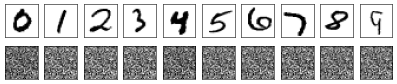

In [9]:
plot_digits()

## Traing Loop

epoch 0: total_loss = 4774.586613769531


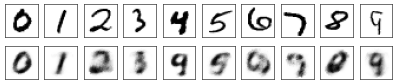

epoch 1: total_loss = 2273.226482747396


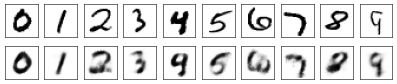

epoch 2: total_loss = 1676.5302284749348


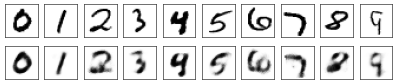

epoch 3: total_loss = 1414.9575587972006


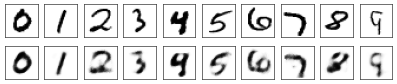

epoch 4: total_loss = 1271.5756673177084


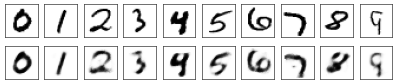

epoch 5: total_loss = 1188.8039146931967


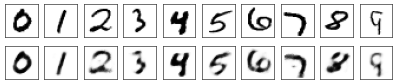

epoch 6: total_loss = 1130.7828504435222


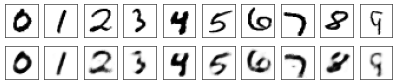

epoch 7: total_loss = 1086.1544599405925


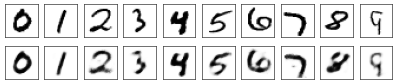

epoch 8: total_loss = 1049.5624419148762


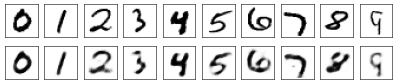

epoch 9: total_loss = 1018.1478952026367


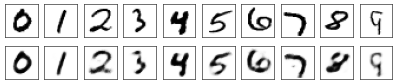

In [10]:
for epoch in range(10):
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device).view(-1, input_dim) # flatten the image
        z, o = model(images)
        loss = ((o-images)**2).sum() # reconstruction loss as measured by mean squared error
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"epoch {epoch}: total_loss = {total_loss/len(train_loader)}")
    plot_digits()

## Use only the encoder of the model

1. Generate all embeddings for test set
2. Initiate T-SNE (t-distributed stochastic neighbor embedding). This is a dimensionaliy reduction method, reducing the embedding of each MNIST datapointinto a 2-dimensional vector. T-SNE is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It is based on Stochastic Neighbor Embedding originally developed by Geoffrey Hinton and Sam Roweis, where Laurens van der Maaten and Hinton proposed the t-distributed variant. It is a nonlinear dimensionality reduction technique for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.
3. Plot the compressed embedding and color each datapoint according its label


In [11]:
model.eval()
all_labels = []
all_embeddings = []
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device).view(-1, input_dim) # flatten the image
        z = model.encode(images)
        all_labels.extend(labels.cpu().numpy().tolist())
        all_embeddings.extend(z.cpu().numpy().tolist())

In [12]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array(all_embeddings)
all_compressed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
all_compressed.shape

(10000, 2)

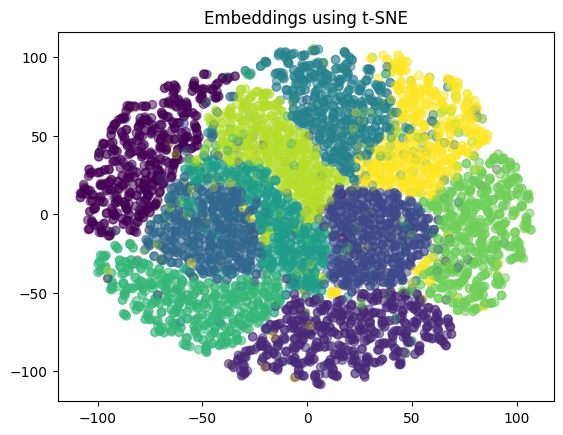

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x1 = [x for x,y in list(all_compressed)]
x2 = [y for x,y in list(all_compressed)]

plt.scatter(x1, x2, c=all_labels, cmap="viridis", alpha=0.3)

plt.title("Embeddings using t-SNE")
plt.show()

Label: 0


<Figure size 640x480 with 0 Axes>

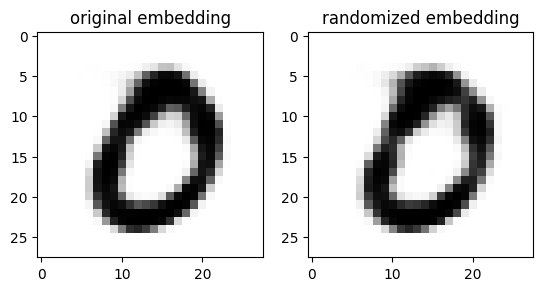

In [50]:
# Sampling
label = all_labels[0]
print("Label:",label)

z = torch.tensor(all_embeddings[0])
img_1 = model.decode(z.to(device))

z_rand = z + torch.randn(20) #add some random as sampling
img_2 = model.decode(z_rand.to(device))
img_1 = (img_1).detach().cpu().numpy()
img_2 = (img_2).detach().cpu().numpy()


plt.figure()
f, axs = plt.subplots(1,2) 
axs[0].imshow(img_1.reshape(28,28), cmap="binary")
axs[0].set_title("original embedding")
axs[1].imshow(img_2.reshape(28,28), cmap="binary")
axs[1].set_title("randomized embedding")

plt.show()


In [51]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
output = cos(z, z_rand)
print(output)

tensor(0.9919)
